# 3D convolution fit

In [1]:
import os
import itertools
import numpy as np
from scipy import stats, signal
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import sys
sys.path.append('../')

In [2]:
from lib.dndnpip import DnDnPip
from lib import resolution as res
from lib.params import mdn, mpip, mdstp
from lib.dalitzphsp import Kibble
from lib.convolution import local_resolution_grid, smeared_pdf
from lib.vartools import generated_to_observables, observables_to_mandelstam
from lib.plots import draw_1d_projections, draw_pdf_projections

In [3]:
from lib.convolution import smear_1d, smear_nd, meshgrid, vectorized_mvn

In [4]:
x = np.linspace(-2, 6, 121)
x.shape

(121,)

In [5]:
sigma = lambda x: np.ones(x.size) * 0.4
pdf = lambda x: stats.norm.pdf(x, 2., 0.5)
smeared = [smear_1d(xi, pdf, sigma) for xi in x]

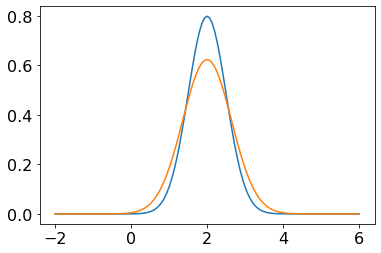

In [6]:
plt.plot(x, pdf(x));
plt.plot(x, smeared);

In [7]:
sum(pdf(x)), sum(smeared)

(14.99999999999999, 14.99999344139051)

In [8]:
N = 100
x_2d = meshgrid(
    [np.linspace(-1, 1, N),
     np.linspace(-1, 1, N)]
).reshape(N, N, 2)
x_2d.shape

(100, 100, 2)

In [9]:
cov0 = np.array([[0.01, 0.00],[0.00, 0.01]])
cov0.shape

(2, 2)

In [10]:
cov_2d = lambda x: np.array([[[0.01, 0.008],[0.008, 0.01]] for _ in range(x.size // 2)])

In [11]:
pdf = lambda x: stats.multivariate_normal.pdf(x, [0., 0.], cov0)

In [12]:
z = pdf(x_2d)

In [14]:
smeared_z = []
for idx in range(N):
    print('.', end='')
    smeared_z.append([])
    for jdx in range(N):
        smeared_z[-1].append(smear_nd(x_2d[idx, jdx], pdf, cov_2d))
smeared_z = np.array(smeared_z)
smeared_z.shape

....................................................................................................

(100, 100)

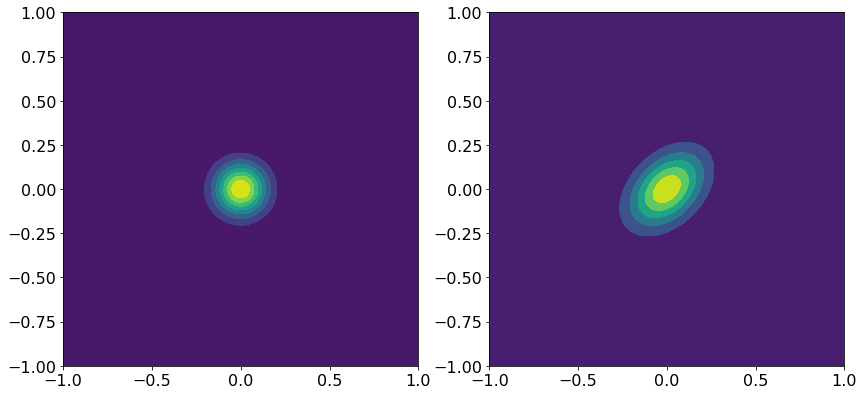

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6.5))
ax[0].contourf(x_2d[:,:,0], x_2d[:,:,1], z);
ax[0].axis('equal');
ax[1].contourf(x_2d[:,:,0], x_2d[:,:,1], smeared_z);
ax[1].axis('equal');

In [17]:
np.sum(z), np.sum(smeared_z)

(2450.2499999999986, 2450.2479463501863)

In [22]:
path_data = '../mcsamples'

In [23]:
from lib.toymc import get_toymc_sample

In [24]:
e, pd, mdpi = get_toymc_sample(40, 1.5, 250, 5000)

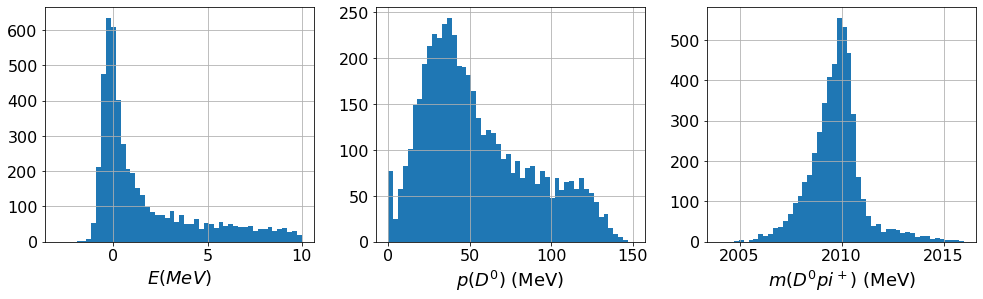

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, e, pd, mdpi, bins=50)
fig.tight_layout()

In [26]:
pdf = DnDnPip(40, 1.5)

In [32]:
N = 101
energy = np.linspace(-3, 10, N)
dmomentum = np.linspace(0, 150, N)
dstmass = np.linspace(2005, 2015, N)

In [33]:
observables = meshgrid([energy, dmomentum, dstmass])
observables.shape

(1030301, 3)

In [34]:
fpdf = pdf.pdf_vars(observables[:,0], observables[:,1], observables[:,2]).reshape(N,N,N)
fpdf.shape

(101, 101, 101)

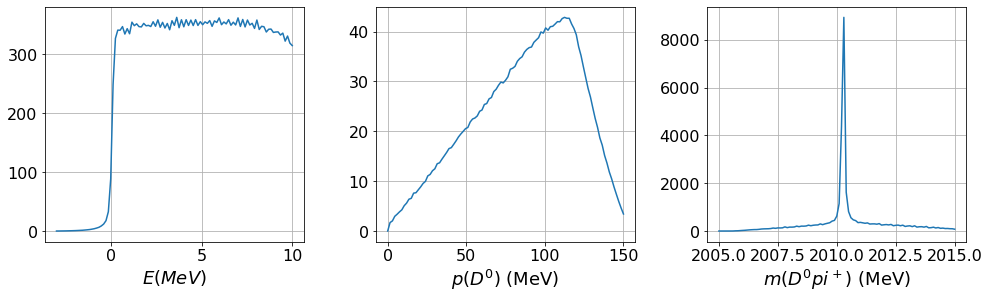

In [61]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_pdf_projections(ax, [energy, dmomentum, dstmass], fpdf)
fig.tight_layout()
fig.savefig('bad_projections.png')

Energy resolution contours

In [44]:
def dumb_pdf(data):
    return stats.multivariate_normal.pdf(data, mean=[0.,0.,0.], cov=np.diag([1, 3, 4]))

In [49]:
dumb_data = meshgrid([np.linspace(-3, 3, 100) for _ in range(3)]).reshape(100,100,100,3)
dumb_data.shape

(100, 100, 100, 3)

In [53]:
dumb_f = dumb_pdf(dumb_data)
dumb_f.shape

(100, 100, 100)

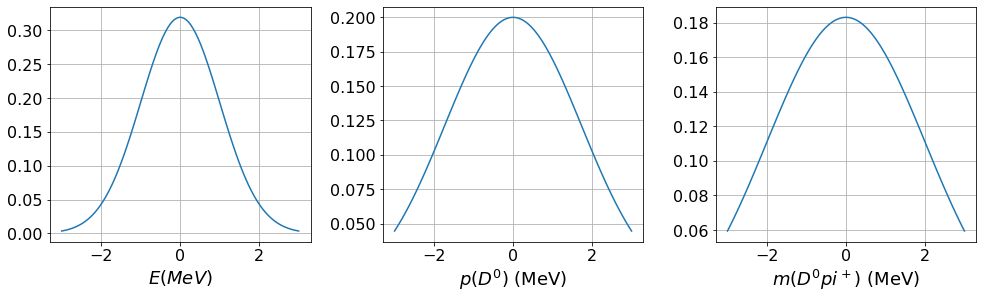

In [54]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_pdf_projections(ax, [np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), np.linspace(-3, 3, 100)], dumb_f)
fig.tight_layout()

In [60]:
s, mddsq, md1pisq = observables_to_mandelstam(e=0, pd=50, md1pi=2009)
s, mddsq, md1pisq, pdf.isInPhsp(s, mddsq, md1pisq)

(15.016444186172492, 13.920514699601885, 4.036080999999999, True)

False